## Задание

Подготовить данные для этапа моделирования (обучения)
    
1. Анализ данных, необходимые корректировки. 
2. Обработать пропуски. 
3. Оценить выбросы. 
4. Корреляция. 
5. Тест на нормальность распределения.
6. Масштабировать и стандартизировать данные.
7. Разделите данные на тренрровачную и тестовую выборку.
8. При обработке пропусков/выбросов/скалировании тестовую и тренировачную выборку обрабатывать отдельно.

## Данные

* Категориальные
    + Образование(`education`)
    + Работа(`job_position`)
    + Семейное положение(`material_status`)
    + Номер предлагаемого тарифа(`tariff_id`)
    + Регион проживания(`living_region`)
    + Пол(`Gender`)
* Вещественные
    + Возраст(`Age`)
    + Сумма кредита(`credit_sum`)
    + Срок кредитования(`credit_month`)
    + Месячный заработок(`monthly_income`)
    + Количество кредитов у клиента(`credit_count`)
    + Количество просроченных кредитов клиента(`overdue_credit_count`)
    + `score_shk` - ???

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler as MMScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import generalize_regions

In [106]:
df = pd.read_csv('data/credit_train.csv', encoding='cp1251', sep=';', decimal=',', index_col='client_id')
df

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
client_id,,,,,,,,,,,,,,
1,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
2,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
3,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
4,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
5,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170742,F,27.0,UNM,SPC,64867.00,12,1.1,0.535257,GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170743,F,24.0,MAR,SPC,17640.00,6,1.6,0.573287,SCH,САНКТ-ПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170744,F,31.0,UNM,SPC,27556.47,10,1.32,0.416098,GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0


### Обработка данных

По очереди анализируем каждый признак и решаем нужно ли с ним что-то делать

#### Колонка `living_region`

Приводим все названия одного региона к одному виду

In [107]:
df.living_region = df.living_region.apply(generalize_regions.generalize_regions)
np.unique(df.living_region.values)

array(['АЛТАЙСКИЙ КРАЙ', 'АМУРСКАЯ ОБЛАСТЬ', 'АРХАНГЕЛЬСКАЯ ОБЛАСТЬ',
       'АСТРАХАНСКАЯ ОБЛАСТЬ', 'БЕЛГОРДОСКАЯ ОБЛАСТЬ', 'БРЯНСКАЯ ОБЛАСТЬ',
       'ВЛАДИМИРСКАЯ ОБЛАСТЬ', 'ВОЛГОГРАДСКАЯ ОБЛАСТЬ',
       'ВОЛОГОДСКАЯ ОБЛАСТЬ', 'ВОРОНЕЖСКАЯ ОБЛАСТЬ',
       'ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
       'ЕВРЕЙСКАЯ АВТОНОМНАЯ ОБЛАСТЬ', 'ЗАБАЙКАЛЬСКИЙ КРАЙ',
       'ИВАНОВСКАЯ ОБЛАСТЬ', 'ИРКУТСКАЯ ОБЛАСТЬ',
       'КАБАРИНО-БАЛКАРСКАЯ РЕСПБЛИКА', 'КАЛИНГРАДСКАЯ ОБЛАСТЬ',
       'КАЛУЖСКАЯ ОБЛАСТЬ', 'КАМЧАТСКИЙ КРАЙ', 'КЕМЕРОВСКАЯ ОБЛАСТЬ',
       'КИРОВСКАЯ ОБЛАСТЬ', 'КОСТРОМСКАЯ ОБЛАСТЬ', 'КРАСНОДАРСКИЙ КРАЙ',
       'КРАСНОЯРСКИЙ КРАЙ', 'КУРГАНСКАЯ ОБЛАСТЬ', 'КУРСКАЯ ОБЛАСТЬ',
       'ЛЕНИНГРАДСКАЯ ОБЛАСТЬ', 'ЛИПЕЦКАЯ ОБЛАСТЬ', 'МАГАДАНСКАЯ ОБЛАСТЬ',
       'МОСКВА', 'МОСКОВСКАЯ ОБЛАСТЬ', 'МУРМАНСКАЯ ОБЛАСТЬ',
       'НЕНЕЦКИЙ АВТОНОМНЫЙ ОКРУГ', 'НИЖЕГОРОДСКАЯ ОБЛАСТЬ',
       'НОВГОРОДСКАЯ ОБЛАСТЬ', 'НОВОСИБИРСКАЯ ОБЛАСТЬ', 'ОМСКАЯ ОБЛАСТЬ',
       'ОРЕНБУРГСКАЯ ОБЛАСТЬ', 'ПЕНЗЕНСКАЯ 

#### Колонка `gender`

Как видно, пропусков нет. Пропускаем

In [108]:
df.gender.isna().sum()

0

#### Колонка `age`

Развивая мысль средней зарплаты по региону, можно прийти к тому, что от региона меняется не только средняя зарплата, а если ещё дальше, то среднее зависит и не только от региона. Например, средний возраст тоже может сильно разниться от региона к региону и, кроме того, сильно разниться у мужчин и женщин. Из всего этого пришел к следующему методу обработки колонок с пропусками:
1. Выделяем зависимые признаки (например, для `age` это `living_region` и `gender`)
2. Заполняем пропуски средним значением по выбранным зависимым признакам

Поэтому будем заполнять пропуски в этой колонке средним по региону и полу.

In [109]:
mean_age_df = df.groupby(['living_region', 'gender'], as_index=False).age.mean()    

rows = df.age.index[np.isnan(df.age)]
for row_ind in rows:
    row = df.loc[row_ind]
    mean_val = mean_age_df[mean_age_df.living_region == row.living_region][mean_age_df.gender == row.gender].age.item()
    df.loc[row_ind, 'age'] = mean_val

df.age.isna().sum()

/tmp/ipykernel_6059/285313908.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_val = mean_age_df[mean_age_df.living_region == row.living_region][mean_age_df.gender == row.gender].age.item()


0

#### Колонка `marital_status`

Пропуски отсутствуют

In [110]:
df.job_position.isna().sum()

0

#### Колонка `job_position`

Пропуски отсутствуют

In [111]:
df.job_position.isna().sum()

0

#### Колонка `credit_sum`

Заполняем средним значением по региону

In [112]:
mean_credit_sum_df = df.groupby('living_region', as_index=False).credit_sum.mean()

rows = df.credit_sum.index[np.isnan(df.credit_sum)]
for row_ind in rows:
    row = df.loc[row_ind]
    mean_val = mean_credit_sum_df[mean_credit_sum_df.living_region == row.living_region].credit_sum.item()
    df.loc[row_ind, 'credit_sum'] = mean_val

df.credit_sum.isna().sum()

0

#### Колонка `credit_month`

Пропуски отсутствуют

In [113]:
df.credit_month.isna().sum()

0

#### Колонка `tariff_id`

Пропуски отсутствуют

In [114]:
df.tariff_id.isna().sum()

0

#### Колонка `score_shk`

Заполняем пропуским средним значением

In [115]:
df.score_shk.fillna(df.score_shk.mean(), inplace=True)
df.score_shk.isna().sum()

0

#### Колонка `education`

Заполняем наиболее распространенным

In [116]:
df.education.fillna(df.education.value_counts().index[0], inplace=True)
df.education.isna().sum()

0

#### Колонка `monthly_income`

Заполняем средним по региону, полу, возрасту и должности

In [117]:
mean_monthly_income_df = df.groupby(['living_region', 'gender', 'age', 'job_position'], as_index=False).monthly_income.mean()

rows = df.monthly_income.index[np.isnan(df.monthly_income)]
for row_ind in rows:
    row = df.loc[row_ind]
    region = mean_monthly_income_df[mean_monthly_income_df.living_region == row.living_region]
    gender = region[region.gender == row.gender]
    age = gender[gender.age == row.age]
    job = age[age.job_position == row.job_position]

    mean_value = job.monthly_income.item()
    df.loc[row_ind, 'monthly_income'] = mean_val

df.monthly_income.isna().sum()

0

#### Колонка `credit_count`

Заполняем средним по региону, гендеру, зарплате

In [118]:
mean_credit_count_df = df.groupby(['living_region', 'gender', 'monthly_income'], as_index=False).credit_count.mean()

rows = df.credit_count.index[np.isnan(df.credit_count)]
for row_ind in rows:
    row = df.loc[row_ind]
    region = mean_credit_count_df[mean_credit_count_df.living_region == row.living_region]
    gender = region[region.gender == row.gender]
    monthly_income = gender[gender.monthly_income == row.monthly_income]

    mean_value = monthly_income.credit_count.item()
    df.loc[row_ind, 'credit_count'] = mean_val

df.credit_count.isna().sum()

0

#### Колонка `overdue_credit_count`

Используем тот же принцип что и для `credit_count`

In [119]:
mean_overdue_credit_count_df = df.groupby(['living_region', 'gender', 'monthly_income'], as_index=False).overdue_credit_count.mean()

rows = df.overdue_credit_count.index[np.isnan(df.overdue_credit_count)]
for row_ind in rows:
    row = df.loc[row_ind]
    region = mean_overdue_credit_count_df[mean_overdue_credit_count_df.living_region == row.living_region]
    gender = region[region.gender == row.gender]
    monthly_income = gender[gender.monthly_income == row.monthly_income]

    mean_value = monthly_income.overdue_credit_count.item()
    df.loc[row_ind, 'overdue_credit_count'] = mean_val

df.overdue_credit_count.isna().sum()

0

### Оценка выбросов

На ящике с усами можно увидеть наличие "выбросов", но всё это реальные значения, поэтому очищать датасет от них я не буду.

<AxesSubplot:>

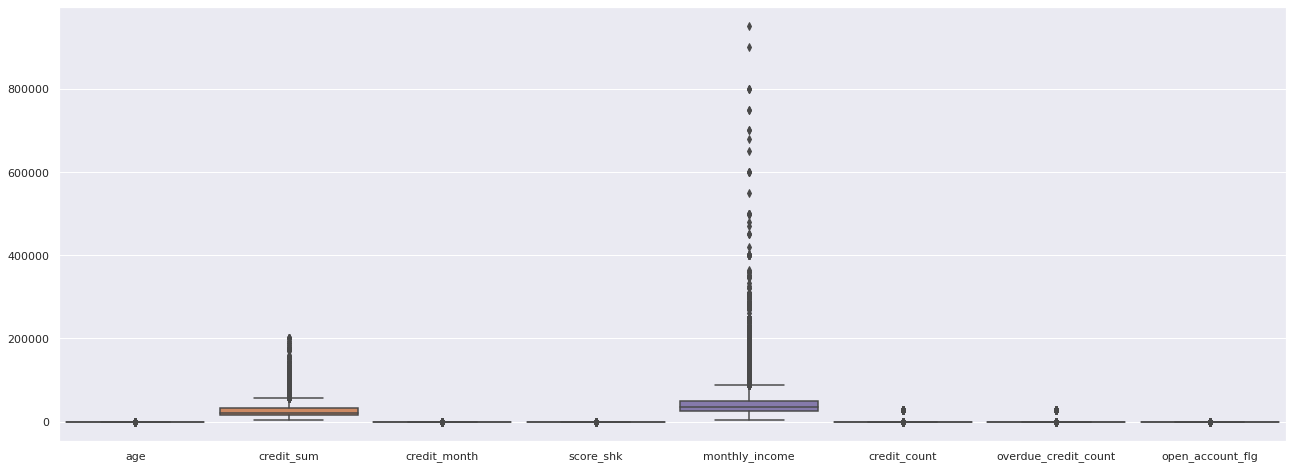

In [120]:
sns.set(rc={'figure.figsize':(22,8)})
sns.boxplot(data=df, width=0.9)

### Корреляция

Коррелирующих признаков не замечено.

<AxesSubplot:>

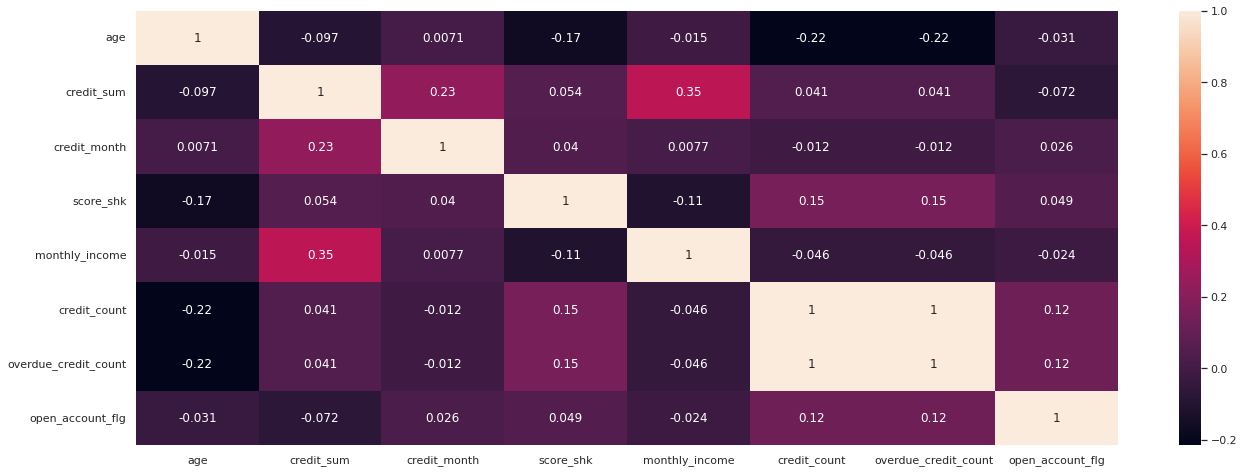

In [121]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)

### Нормальность распределения

Нормальных распределений среди признаков не обнаружено.

age: Отклонить гипотезу о нормальности


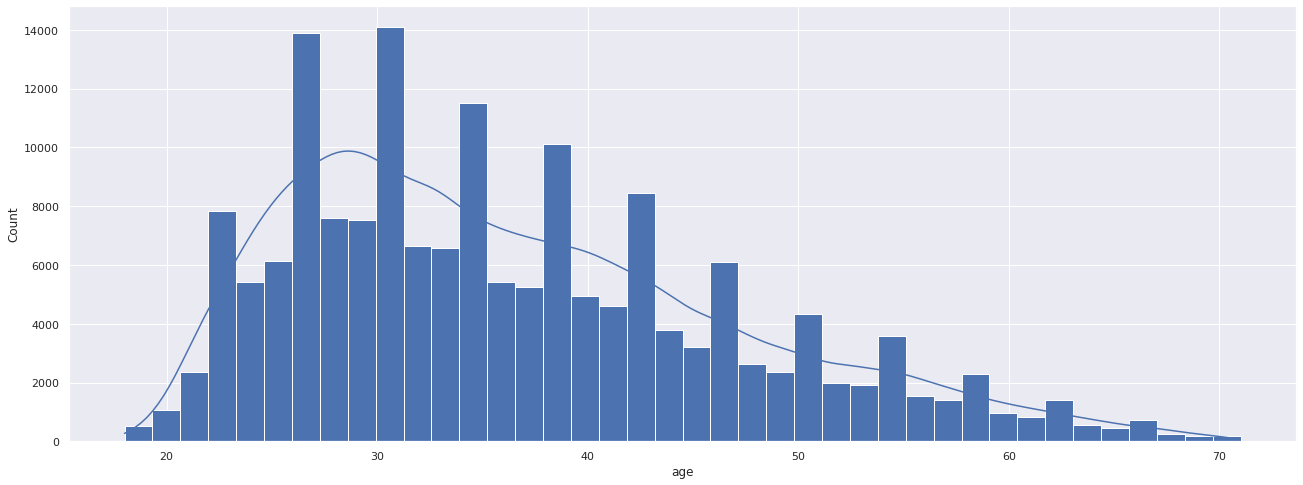

credit_sum: Отклонить гипотезу о нормальности


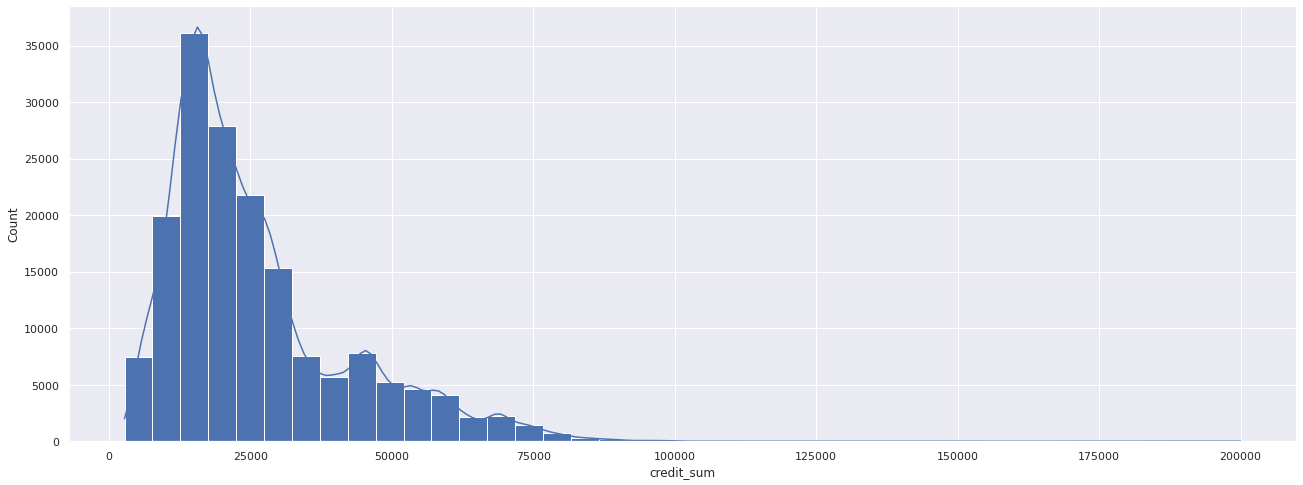

score_shk: Отклонить гипотезу о нормальности


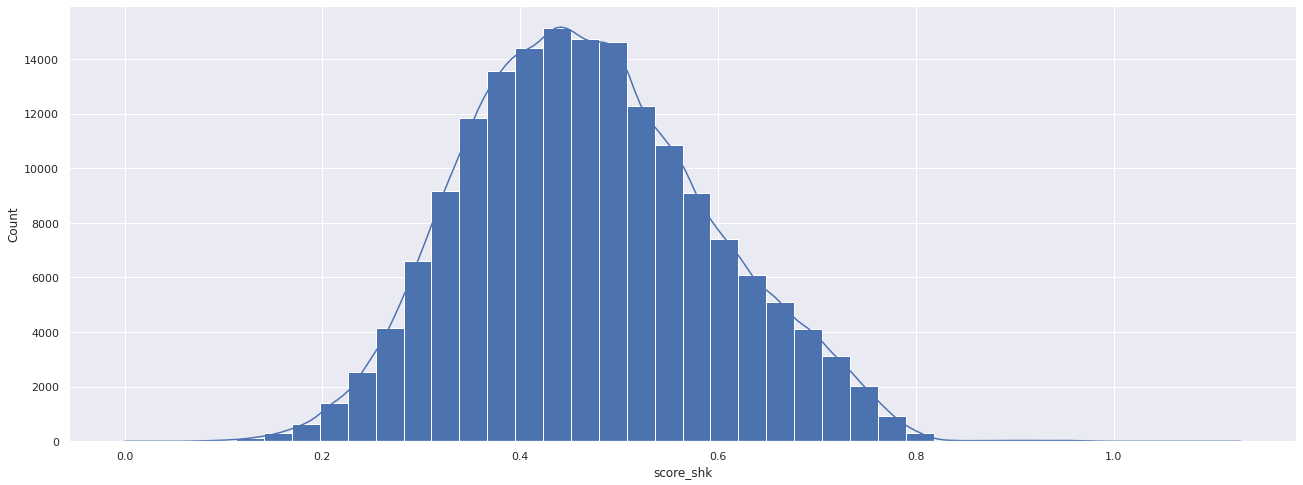

monthly_income: Отклонить гипотезу о нормальности


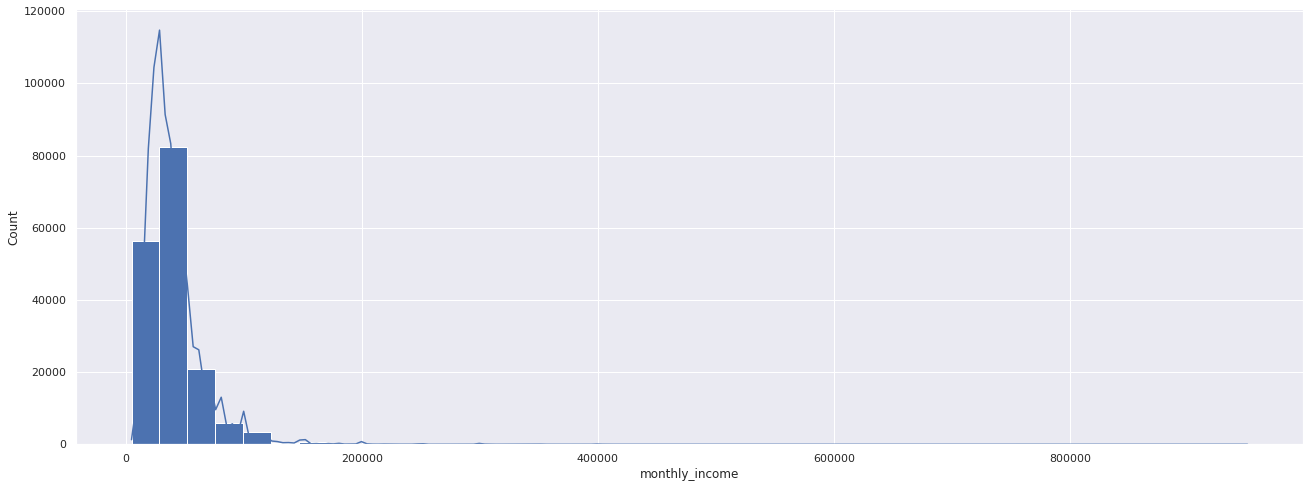

In [122]:
def print_is_normal(dataset, column):
    stat, p = stats.normaltest(dataset[column])
    
    alpha = 0.05
    if p > alpha:
        print(f"{column}: Принять гипотезу о нормальности")
    else:
        print(f"{column}: Отклонить гипотезу о нормальности")

discrete_columns = ['age', 'credit_sum', 'score_shk', 'monthly_income']
for column in discrete_columns:
    print_is_normal(df, column)
    
    sns.histplot(df[column], kde=True, bins = 40, alpha = 1)
    plt.show()

### Масштабирование и стандартизирование данных

#### Кодирировка категориальных признаков

In [123]:
df = pd.concat([df,
           pd.get_dummies(df['gender'], prefix='gender'),
           pd.get_dummies(df['marital_status'], prefix='marital_status'),
           pd.get_dummies(df['job_position'], prefix='job_position'),
           pd.get_dummies(df['education'], prefix='education'),
           pd.get_dummies(df['living_region'], prefix='living_region')],
           axis=1)

In [124]:
df = df.drop(['gender', 'marital_status', 'job_position', 'education', 'living_region'], axis=1)

#### Получение тренировачной и тестовой выборок

In [125]:
y = 'open_account_flg'

X = df.columns.to_list()
X.remove(y)

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], train_size=0.7, random_state=0)

In [126]:
print(f"Train set shape: {X_train.shape}\nTest set size: {X_test.shape}\n")

Train set shape: (119522, 119)
Test set size: (51224, 119)



#### Масштабирование данных

In [127]:
mm_scaler = MMScaler(feature_range=(-1, 1))
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.fit_transform(X_test)

### Моделирование

При подборе параметров модели(подбирались вручную), было выявлено наиболее оптимальное значение глубины поиска равное 25. Значительное увеличение параметра `n_estimators` привело лишь к незначительному увеличению точности модели (стало лучше ~0.0002), но к более заметному улучшению показателя **AUC** (рост на ~0.006). Дальнейшее увеличение этого параметра положительных результатов не привело.

In [143]:
rfc = RandomForestClassifier(max_depth=25, n_estimators=500, random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.8309971888177416

In [144]:
y_pred = rfc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.7542650670697146